# Data analysis
This jupyter notebook will quanitfy and analyze the alpha generated by different actively managed mutual funds.  These mutual funds were chosen through a process that Richard will detail.

The goal of the project is two-fold.
- Determine the portion of returns for a given strategy that arises from exposure to various market or systematic risk factors
- Identify and quanityf the 'idiosyncratic alpha'

# Setup

In [2]:
from tools import get_mutual_fund_data, get_bond_data, get_ff_data, get_index_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from data_tools import capm, ff_3, ff_5, reg_date_range, capm_index, corr_index
from ind_data_tools import data_analyze_strat_base, data_analyze_strat_bench, data_analyze_strat_5

In [3]:
pd.set_option('display.max_rows', 10)

## Import data
First, we import data using the tools that Richard wrote.  This allows us to get mutual fund data in a dictionary.  In addition, we also want FF factors and CAPM factors to do some basic analysis

In [4]:
mf_dict = get_mutual_fund_data()
ff_df = get_ff_data()
bond_df = get_bond_data()
index_dict = get_index_data()


Mutual Fund Data


c:\Users\dklro\Documents\Fall 2023\15.433\15-4331-final-project\tools.py:129: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/mutual_funds/mutual_fund_data.csv",skiprows=0).dropna(how='any')


Total number of rows: 408031
Total number of funds with enough data: 1608
Funds with no data: 25
Funds with less than 5 years of data: 65
Columns: Index(['ticker', 'date', 'total_net_assets', 'total_returns',
       'net_asset_value', 'nav_return'],
      dtype='object')

FF Data
          date  Mkt-RF   SMB   HML   RMW   CMA    RF
0   1963-07-31   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1   1963-08-31    5.07 -0.80  1.80  0.36 -0.35  0.25
2   1963-09-30   -1.57 -0.52  0.13 -0.71  0.29  0.27
3   1963-10-31    2.53 -1.39 -0.10  2.80 -2.01  0.29
4   1963-11-30   -0.85 -0.88  1.75 -0.51  2.24  0.27
..         ...     ...   ...   ...   ...   ...   ...
719 2023-06-30    6.46  1.34 -0.26  2.18 -1.62  0.40
720 2023-07-31    3.21  2.86  4.11 -0.57  0.57  0.45
721 2023-08-31   -2.39 -3.65 -1.06  3.43 -2.37  0.45
722 2023-09-30   -5.24 -1.80  1.52  1.86 -0.83  0.43
723 2023-10-31   -3.18 -4.03  0.19  2.47 -0.66  0.47

[724 rows x 7 columns]

Bond Data
Columns: Index(['date', '30 Year Bond Return', '

In [5]:
len(mf_dict)

1608

## Data set
Let us first take a look at our data set to see what we are working with.  We are only working with actively managed funds and primarily those with the largest AUM.

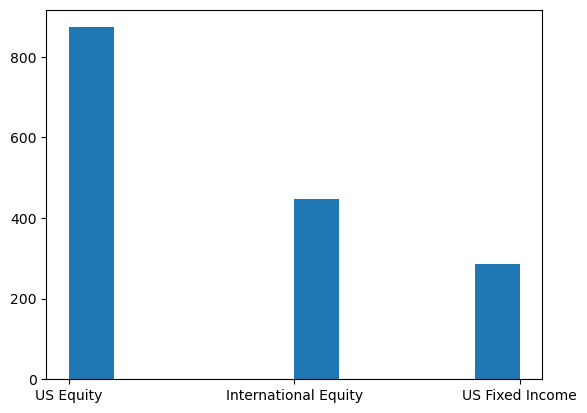

In [6]:
mf_types = list(mf_dict.keys())
mf_areas = [arr[1] for arr in mf_types]
plt.hist(mf_areas)
plt.show()

### Example df below

In [7]:
mf_dict[mf_types[10]]

,ticker,date,total_net_assets,total_returns,net_asset_value,nav_return
0,LBSCX,2002-12-31,0.100,-0.043162,8.4900000,NaN
1,LBSCX,2003-01-31,0.100,-0.029446,8.2400000,-0.029446
2,LBSCX,2003-02-28,0.100,-0.055825,7.7800000,-0.055825
3,LBSCX,2003-03-31,0.200,0.001303,7.7800000,0.000000
4,LBSCX,2003-04-30,0.200,0.073265,8.3500000,0.073265
...,...,...,...,...,...,...
245,LBSCX,2023-05-31,1231.500,-0.029601,27.2100000,-0.029601
246,LBSCX,2023-06-30,1290.600,0.058508,28.7300000,0.055862
247,LBSCX,2023-07-31,1326.400,0.034807,29.7300000,0.034807
248,LBSCX,2023-08-31,1284.600,-0.022200,29.0700000,-0.022200


# US Equity
First, let us look at those actively managed US equity funds

## Get US Equity Data specifically

In [8]:
mf_types = list(mf_dict.keys())
us_eq_data = {k[2]:[] for k in mf_dict.keys() if 'US Equity' in k}

for mf_key, mf_val in mf_dict.items():
    if mf_key[2] in us_eq_data.keys():
        us_eq_data[mf_key[2]].append(mf_val)

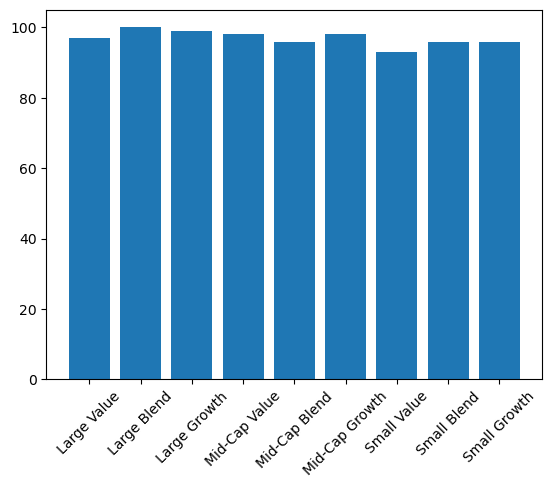

In [9]:
us_amount = [len(arr) for arr in us_eq_data.values()]
plt.bar(us_eq_data.keys(), us_amount)
plt.xticks(rotation=45)
plt.show()

## Averages
This portion focuses on establishing the average values for a grouping of mutual funds

### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

#### CAPM on all listed companies
F-F data file used here

This takes an average of all mututal fund alpha and betas in a certain category

In [10]:
# Example usage of the capm function
capm(us_eq_data['Large Blend'][0], ff_df)

{'const': -0.4729943515703532, 'Mkt-RF': 0.8108697503318263}

In [11]:
us_eq_alphas_c = []
us_eq_alphas_std_c = []
us_eq_betas_c = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        result = capm(ticker, ff_df)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['Mkt-RF'])
    us_eq_alphas_c.append(np.mean(temp_alpha))
    us_eq_alphas_std_c.append(np.std(temp_alpha))
    us_eq_betas_c.append(np.mean(temp_beta))

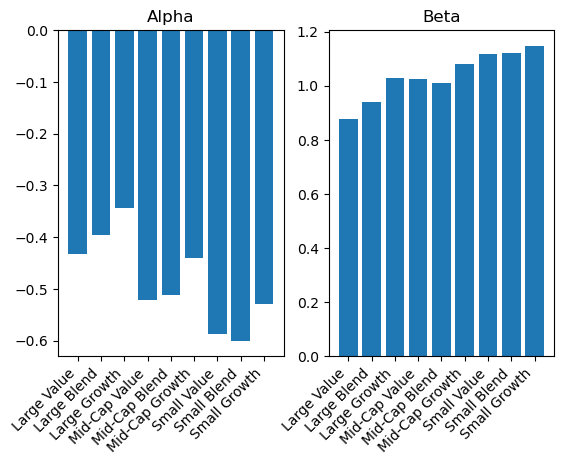

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_data.keys(), us_eq_alphas_c)
ax2.bar(us_eq_data.keys(), us_eq_betas_c)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

#### CAPM on benchmark
Here instead we consider the market return as the benchmark index return

This again takes an average of all mutual fund alpha and beta within a category with the market return as benchmark

In [13]:
us_index = {k[2]: v for k, v in index_dict.items() if 'US Equity' in k}

In [14]:
us_idx_alphas_c = []
us_idx_betas_c = []
us_idx_alphas_std_c = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = capm_index(ticker, ff_df, us_index[strat], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['beta'])
    us_idx_alphas_c.append(np.mean(temp_alpha))
    us_idx_betas_c.append(np.mean(temp_beta))
    us_idx_alphas_std_c.append(np.std(temp_alpha))

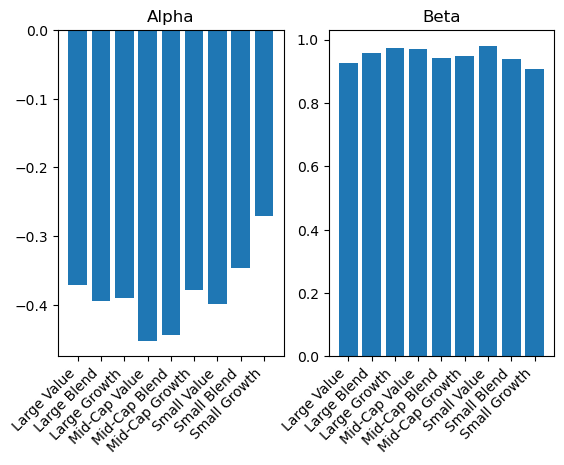

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_data.keys(), us_idx_alphas_c)
ax2.bar(us_eq_data.keys(), us_idx_betas_c)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

### FF 3-Factor
This is the 3-factor model including SMB and HML

In [16]:
us_alphas_3 = []
us_betas_3 = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = reg_date_range(ticker, ff_df, ['Mkt-RF', 'SMB', 'HML'], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
    us_alphas_3.append(np.mean(temp_alpha))

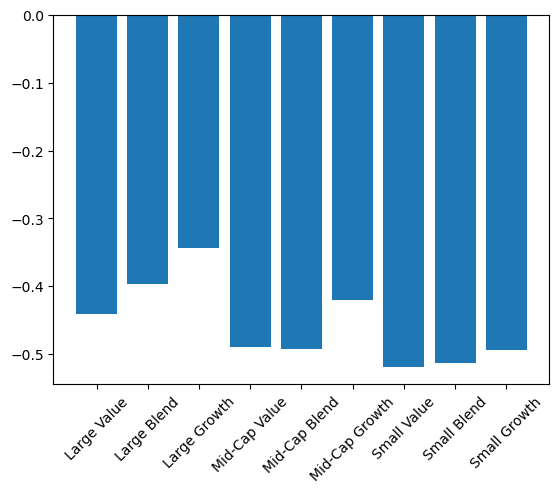

In [17]:
plt.bar(us_eq_data.keys(), us_alphas_3)
plt.xticks(rotation=45)
plt.show()

### FF 5-Factor
This is the 3-factor model including SMB and HML.  RMW and CMA as well

In [18]:
us_alphas_5 = []
us_betas_5 = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        end_date = ticker['date'].iloc[-1]
        result = reg_date_range(ticker, ff_df, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
    us_alphas_5.append(np.mean(temp_alpha))

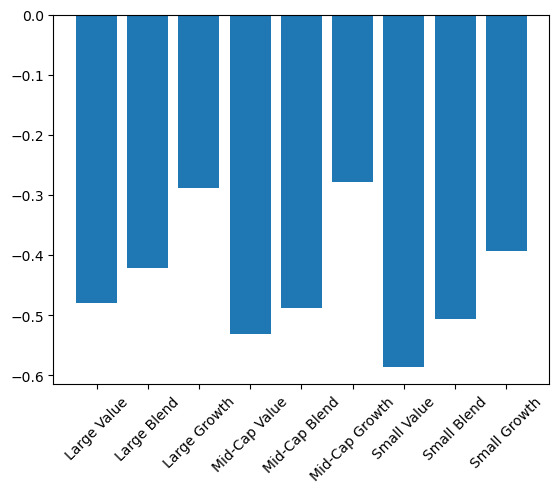

In [19]:
plt.bar(us_eq_data.keys(), us_alphas_5)
plt.xticks(rotation=45)
plt.show()

### Combined bar graph of alpha from FF and CAPM

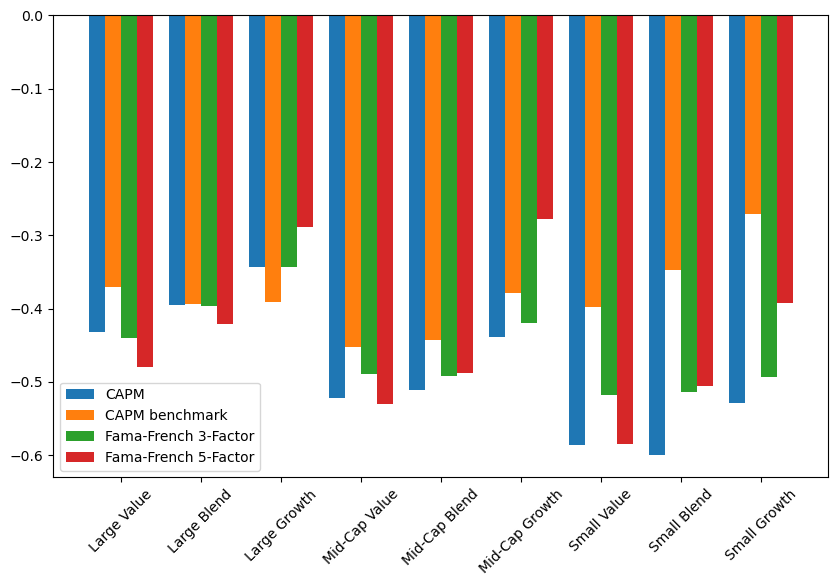

In [20]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_data.keys()))


ax.bar(idx-0.3, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx-0.1, us_idx_alphas_c, 0.2, label='CAPM benchmark')
ax.bar(idx+0.1, us_alphas_3, 0.2, label='Fama-French 3-Factor')
ax.bar(idx+0.3, us_alphas_5, 0.2, label='Fama-French 5-Factor')


ax.set_xticks(idx)
ax.set_xticklabels(us_eq_data.keys(), rotation=45)
ax.legend()
plt.show()

### Find results from date range
We can now look at the results from a data range more specifically.  The function below is an example of being able to do that

Probably looking at a date range after GFC and before Covid has the least randomness or impact of systematic risk.  Could do more looking into regions of low vol.

In [21]:
between_alpha = []
gfc_alpha = []
covid_alpha = []

for strat in us_eq_data.keys():
    temp_between_alpha=[]
    temp_gfc_alpha = []
    temp_covid_alpha = []
    for ticker in us_eq_data[strat]:
        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20100101', '20200101')
        if result == None:
            pass
        else:
            temp_between_alpha.append(result['const'])

        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20071201', '20090601')
        if result == None:
            pass
        else:
            temp_gfc_alpha.append(result['const'])

        result = reg_date_range(ticker, ff_df, ['Mkt-RF'], '20200201', '20220101')
        if result == None:
            pass
        else:
            temp_covid_alpha.append(result['const'])
    
    between_alpha.append(np.mean(temp_between_alpha))
    gfc_alpha.append(np.mean(temp_gfc_alpha))
    covid_alpha.append(np.mean(temp_covid_alpha))

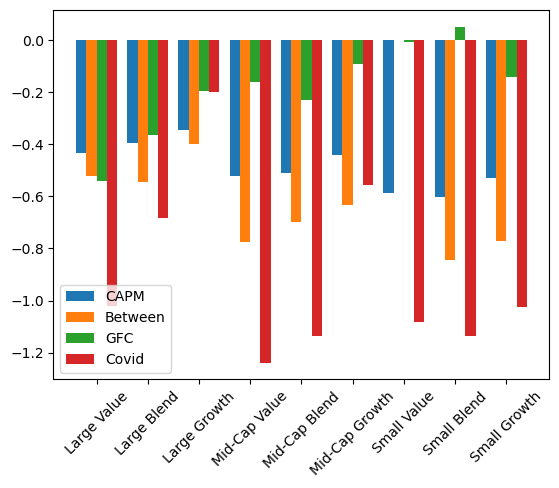

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_data.keys()))


ax.bar(idx-0.3, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx-0.1, between_alpha, 0.2, label='Between')
ax.bar(idx+0.1, gfc_alpha, 0.2, label='GFC')
ax.bar(idx+0.3, covid_alpha, 0.2, label='Covid')

ax.set_xticks(idx)
ax.set_xticklabels(us_eq_data.keys(), rotation=45)
ax.legend()
plt.show()

### Correlations between MF and benchmark

In [23]:
us_corr = []
for strat in us_eq_data.keys():
    temp_corr=[]
    for ticker in us_eq_data[strat]:
        start_date = ticker['date'][1] if ticker['date'][1] > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = corr_index(ticker, us_index[strat], start_date, end_date)
        if result == None:
            continue
        temp_corr.append(result)
    us_corr.append(np.mean(temp_corr))

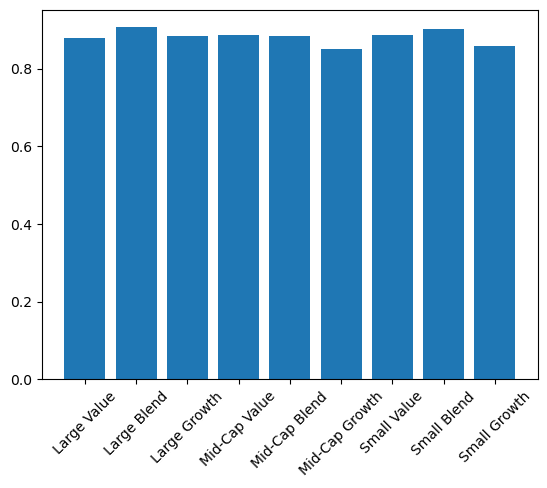

In [24]:
plt.bar(us_eq_data.keys(), us_corr)
plt.xticks(rotation=45)
plt.show()

## Individual strategies

In [25]:
ind_alphas_c = []
ind_betas_c = []
fund_tickers = []

for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    temp_tickers = []
    for ticker in us_eq_data[strat]:
        result = capm(ticker, ff_df)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['Mkt-RF'])
        temp_tickers.append(ticker['ticker'].iloc[0])
    ind_alphas_c.append(temp_alpha)
    ind_betas_c.append(temp_beta)
    fund_tickers.append(temp_tickers)

ind_idx_alphas_c = []
ind_idx_betas_c = []
fund_tickers_idx = []
ind_corr = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    temp_tickers=[]
    temp_corr=[]
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        start_date = start_date if start_date > us_index[strat]['Date'][1] else us_index[strat]['Date'][1]
        end_date = ticker['date'].iloc[-1]
        result = capm_index(ticker, ff_df, us_index[strat], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['beta'])
        temp_tickers.append(ticker['ticker'].iloc[0])
        temp_corr.append(corr_index(ticker, us_index[strat], start_date, end_date))
    ind_idx_alphas_c.append(temp_alpha)
    ind_idx_betas_c.append(temp_beta)
    fund_tickers_idx.append(temp_tickers)
    ind_corr.append(temp_corr)

ind_alphas_5 = []
ind_betas_5 = []
ind_smbs_5 = []
ind_hmls_5 = []
ind_rmws_5 = []
ind_cmas_5 = []
for strat in us_eq_data.keys():
    temp_alpha=[]
    temp_beta=[]
    temp_smb = []
    temp_hml = []
    temp_rmw = []
    temp_cma = []
    for ticker in us_eq_data[strat]:
        start_date = ff_df['date'][0] if ff_df['date'][0] > ticker['date'][1] else ticker['date'][1]
        end_date = ticker['date'].iloc[-1]
        result = reg_date_range(ticker, ff_df, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], start_date, end_date)
        if result == None:
            continue
        temp_alpha.append(result['const'])
        temp_beta.append(result['Mkt-RF'])
        temp_smb.append(result['SMB'])
        temp_hml.append(result['HML'])
        temp_rmw.append(result['RMW'])
        temp_cma.append(result['CMA'])
    ind_alphas_5.append(temp_alpha)
    ind_betas_5.append(temp_beta)
    ind_smbs_5.append(temp_smb)
    ind_hmls_5.append(temp_hml)
    ind_rmws_5.append(temp_rmw)
    ind_cmas_5.append(temp_cma)

### Large value

In [26]:
strat=0
strat_name = 'Large Value'

#### Regular CAPM

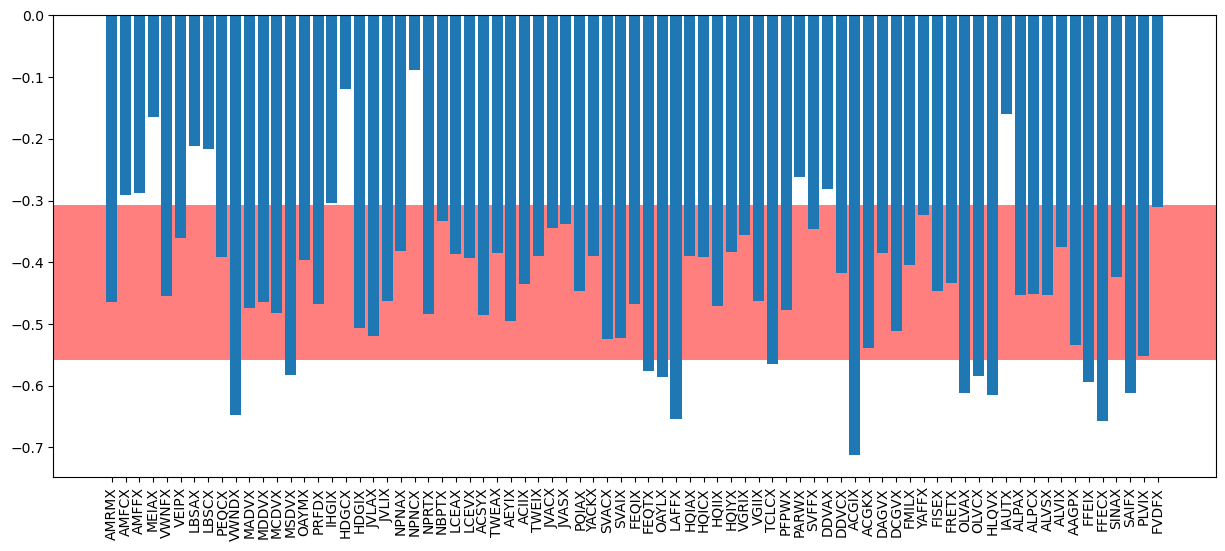

In [27]:
fig = plt.figure(figsize=(15,6))

plt.axhspan(us_eq_alphas_c[strat]-us_eq_alphas_std_c[strat], us_eq_alphas_c[strat]+us_eq_alphas_std_c[strat], facecolor='r', alpha=0.5)
plt.bar(fund_tickers[strat], ind_alphas_c[strat])
plt.xticks(rotation=90)
plt.show()

In [28]:
n=5
largest_index = sorted(range(len(ind_alphas_c[strat])), key = lambda sub: ind_alphas_c[strat][sub])[-n:]
best_alpha_mf = [fund_tickers[strat][i] for i in largest_index]
print(f'The largest alpha funds by CAPM marked to whole market are {best_alpha_mf}.  Note that the best one is last.')

The largest alpha funds by CAPM marked to whole market are ['LBSAX', 'MEIAX', 'IAUTX', 'HDGCX', 'NPNCX'].  Note that the best one is last.


In [29]:
above_std = [idx for idx, val in enumerate(ind_alphas_c[strat]) if val > us_eq_alphas_c[strat]+us_eq_alphas_std_c[strat]]
above_std_mf = [fund_tickers[strat][i] for i in above_std]
print(f'The mutual funds that are 1 stdev above mean with benchmark alpha are {above_std_mf}')

The mutual funds that are 1 stdev above mean with benchmark alpha are ['AMFCX', 'AMFFX', 'MEIAX', 'LBSAX', 'LBSCX', 'IHGIX', 'HDGCX', 'NPNCX', 'PARWX', 'DDVAX', 'IAUTX']


In [30]:
below_std = [idx for idx, val in enumerate(ind_alphas_c[strat]) if val < us_eq_alphas_c[strat]-us_eq_alphas_std_c[strat]]
below_std_mf = [fund_tickers[strat][i] for i in below_std]
print(f'The mutual funds that are 1 stdev below mean with benchmark alpha are {below_std_mf}')

The mutual funds that are 1 stdev below mean with benchmark alpha are ['VWNDX', 'MSDVX', 'FEQTX', 'OAYLX', 'LAFFX', 'TCLCX', 'ACGIX', 'OLVAX', 'OLVCX', 'HLQVX', 'FFEIX', 'FFECX', 'SAIFX']


In [31]:
below_std_beta = [ind_betas_c[strat][i] for i in below_std]
above_std_beta = [ind_betas_c[strat][i] for i in above_std]
print(f'Average beta of below stdev alpha is {np.mean(below_std_beta)} with a stdev on beta of {np.std(below_std_beta)}')
print(f'Average beta of above stdev alpha is {np.mean(above_std_beta)} with a stdev on beta of {np.std(above_std_beta)}')

Average beta of below stdev alpha is 0.9521717152658417 with a stdev on beta of 0.11186015059528046
Average beta of above stdev alpha is 0.8261711233636543 with a stdev on beta of 0.11280703987442978


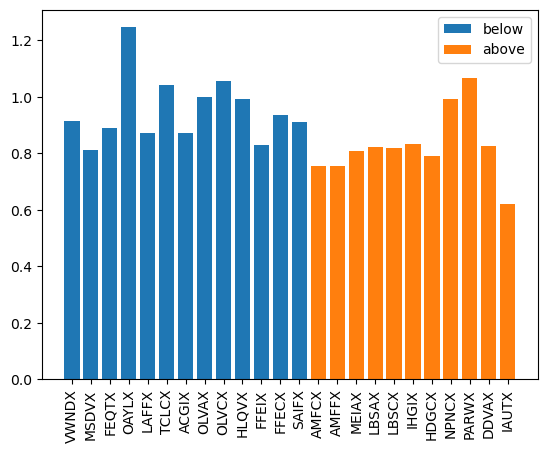

In [32]:
plt.bar(below_std_mf, below_std_beta, label='below')
plt.bar(above_std_mf, above_std_beta, label='above')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Benchmark CAPM

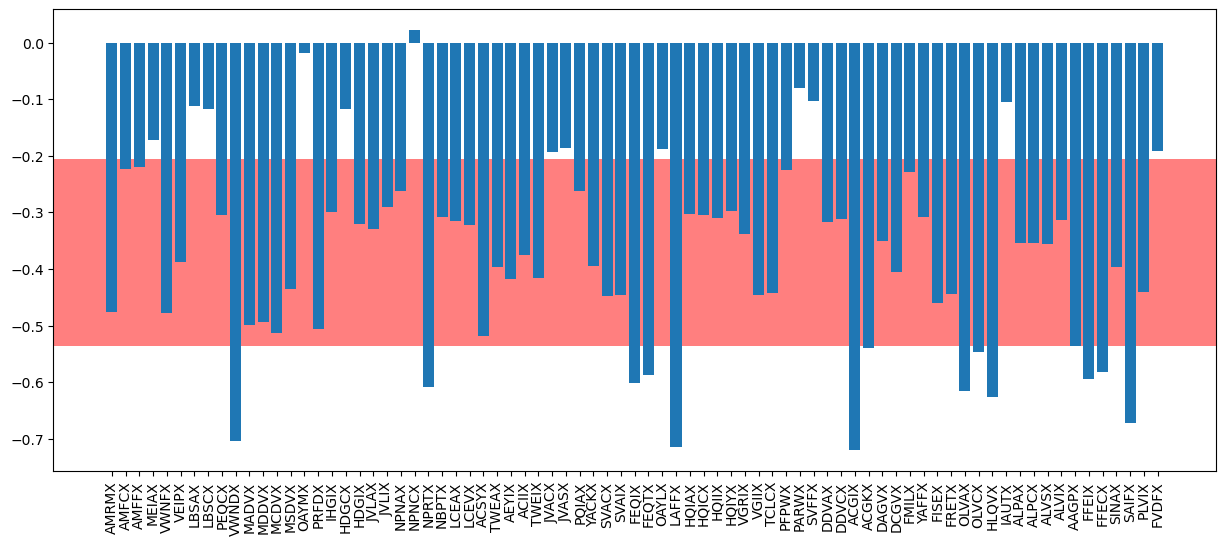

In [33]:
fig = plt.figure(figsize=(15,6))

plt.axhspan(us_idx_alphas_c[strat]-us_idx_alphas_std_c[strat], us_idx_alphas_c[strat]+us_idx_alphas_std_c[strat], facecolor='r', alpha=0.5)
plt.bar(fund_tickers_idx[strat], ind_idx_alphas_c[strat])
plt.xticks(rotation=90)
plt.show()

In [34]:
n=5
largest_index = sorted(range(len(ind_idx_alphas_c[strat])), key = lambda sub: ind_idx_alphas_c[strat][sub])[-n:]
best_alpha_mf = [fund_tickers_idx[strat][i] for i in largest_index]
print(f'The largest alpha funds by CAPM marked to benchmask are {best_alpha_mf}.  Note last one is best one')

The largest alpha funds by CAPM marked to benchmask are ['IAUTX', 'SVFFX', 'PARWX', 'OAYMX', 'NPNCX'].  Note last one is best one


In [35]:
above_std_index = [idx for idx, val in enumerate(ind_idx_alphas_c[strat]) if val > us_idx_alphas_c[strat]+us_idx_alphas_std_c[strat]]
above_std_mf = [fund_tickers_idx[strat][i] for i in above_std_index]
print(f'The mutual funds that are 1 stdev above mean with benchmark alpha are {above_std_mf}')

The mutual funds that are 1 stdev above mean with benchmark alpha are ['MEIAX', 'LBSAX', 'LBSCX', 'OAYMX', 'HDGCX', 'NPNCX', 'JVACX', 'JVASX', 'OAYLX', 'PARWX', 'SVFFX', 'IAUTX', 'FVDFX']


In [36]:
below_std_index = [idx for idx, val in enumerate(ind_idx_alphas_c[strat]) if val < us_idx_alphas_c[strat]-us_idx_alphas_std_c[strat]]
below_std_mf = [fund_tickers_idx[strat][i] for i in below_std_index]
print(f'The mutual funds that are 1 stdev above mean with benchmark alpha are {below_std_mf}')

The mutual funds that are 1 stdev above mean with benchmark alpha are ['VWNDX', 'NPRTX', 'FEQIX', 'FEQTX', 'LAFFX', 'ACGIX', 'ACGKX', 'OLVAX', 'OLVCX', 'HLQVX', 'FFEIX', 'FFECX', 'SAIFX']


In [37]:
below_std_beta = [ind_idx_betas_c[strat][i] for i in below_std_index]
above_std_beta = [ind_idx_betas_c[strat][i] for i in above_std_index]
print(f'Average beta of below stdev alpha is {np.mean(below_std_beta)} with a stdev on beta of {np.std(below_std_beta)}')
print(f'Average beta of above stdev alpha is {np.mean(above_std_beta)} with a stdev on beta of {np.std(above_std_beta)}')

Average beta of below stdev alpha is 0.990536640861027 with a stdev on beta of 0.0637126260348924
Average beta of above stdev alpha is 0.992416202847012 with a stdev on beta of 0.16830835583947118


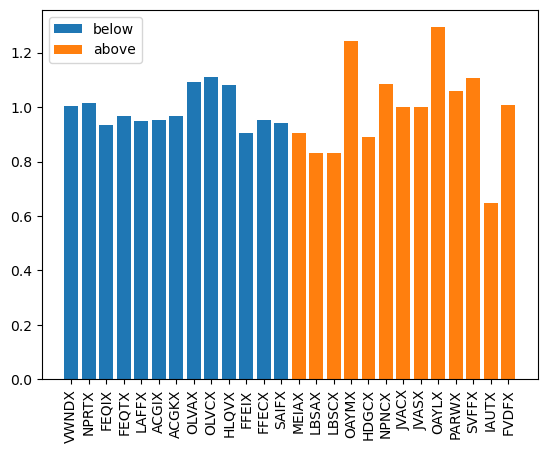

In [38]:
plt.bar(below_std_mf, below_std_beta, label='below')
plt.bar(above_std_mf, above_std_beta, label='above')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [39]:
below_std_corr = [ind_corr[strat][i] for i in below_std_index]
above_std_corr = [ind_corr[strat][i] for i in above_std_index]
print(f'Average corr of below stdev alpha is {np.mean(below_std_corr)} with a stdev on corr of {np.std(below_std_corr)}')
print(f'Average corr of above stdev alpha is {np.mean(above_std_corr)} with a stdev on corr of {np.std(above_std_corr)}')

Average corr of below stdev alpha is 0.8632785705298033 with a stdev on corr of 0.05909926007262963
Average corr of above stdev alpha is 0.8709781249709777 with a stdev on corr of 0.14124593374611236


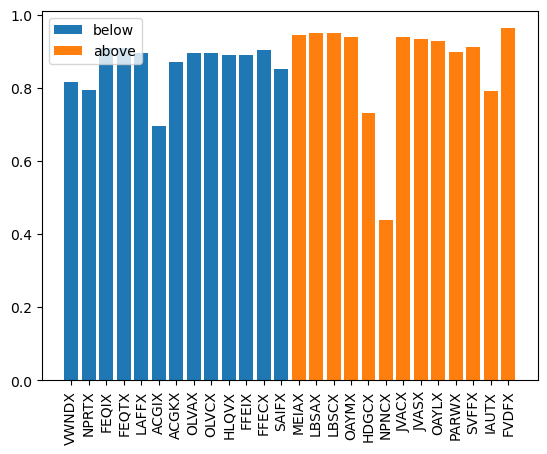

In [40]:
plt.bar(below_std_mf, below_std_corr, label='below')
plt.bar(above_std_mf, above_std_corr, label='above')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### 5-Factor

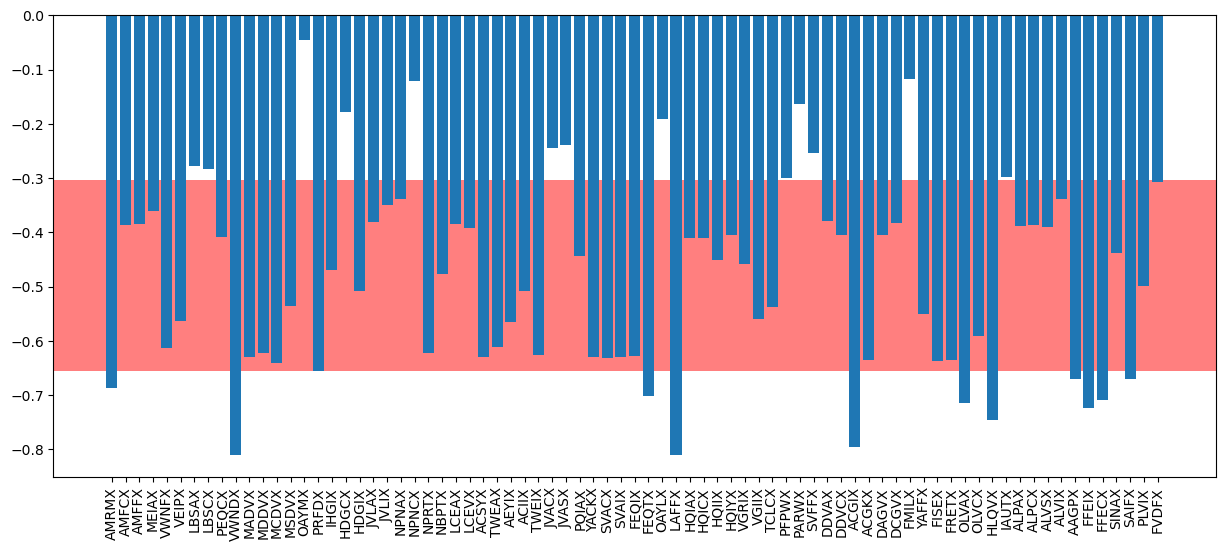

In [41]:
fig = plt.figure(figsize=(15,6))

plt.axhspan(np.mean(ind_alphas_5[strat])-np.std(ind_alphas_5[strat]), np.mean(ind_alphas_5[strat])+np.std(ind_alphas_5[strat]), facecolor='r', alpha=0.5)
plt.bar(fund_tickers[strat], ind_alphas_5[strat])
plt.xticks(rotation=90)
plt.show()

In [42]:
n=5
largest_index = sorted(range(len(ind_alphas_5[strat])), key = lambda sub: ind_alphas_5[strat][sub])[-n:]
best_alpha_mf = [fund_tickers[strat][i] for i in largest_index]
print(f'The largest alpha funds by 5-factor are {best_alpha_mf}.  Note last one is best one')

The largest alpha funds by 5-factor are ['HDGCX', 'PARWX', 'NPNCX', 'FMILX', 'OAYMX'].  Note last one is best one


In [43]:
above_std_5 = [idx for idx, val in enumerate(ind_alphas_5[strat]) if val > np.mean(ind_alphas_5[strat])+np.std(ind_alphas_5[strat])]
above_std_mf = [fund_tickers[strat][i] for i in above_std_5]
print(f'The mutual funds that are 1 stdev above mean with 5-factor alpha are {above_std_mf}')

The mutual funds that are 1 stdev above mean with 5-factor alpha are ['LBSAX', 'LBSCX', 'OAYMX', 'HDGCX', 'NPNCX', 'JVACX', 'JVASX', 'OAYLX', 'PFPWX', 'PARWX', 'SVFFX', 'FMILX', 'IAUTX']


In [44]:
below_std_5 = [idx for idx, val in enumerate(ind_alphas_5[strat]) if val < np.mean(ind_alphas_5[strat])-np.std(ind_alphas_5[strat])]
below_std_mf = [fund_tickers[strat][i] for i in below_std_5]
print(f'The mutual funds that are 1 stdev above mean with 5-factor alpha are {below_std_mf}')

The mutual funds that are 1 stdev above mean with 5-factor alpha are ['AMRMX', 'VWNDX', 'FEQTX', 'LAFFX', 'ACGIX', 'OLVAX', 'HLQVX', 'AAGPX', 'FFEIX', 'FFECX', 'SAIFX']


In [45]:
below_std_beta = [ind_betas_5[strat][i] for i in below_std_5]
above_std_beta = [ind_betas_5[strat][i] for i in above_std_5]
print(f'Average beta of below stdev alpha is {np.mean(below_std_beta)} with a stdev on beta of {np.std(below_std_beta)}')
print(f'Average beta of above stdev alpha is {np.mean(above_std_beta)} with a stdev on beta of {np.std(above_std_beta)}')
print('\n')

below_std_smb = [ind_smbs_5[strat][i] for i in below_std_5]
above_std_smb = [ind_smbs_5[strat][i] for i in above_std_5]
print(f'Average SMB of below stdev alpha is {np.mean(below_std_smb)} with a stdev on SMB of {np.std(below_std_smb)}')
print(f'Average SMB of above stdev alpha is {np.mean(above_std_smb)} with a stdev on SMB of {np.std(above_std_smb)}')
print('\n')

below_std_hml = [ind_hmls_5[strat][i] for i in below_std_5]
above_std_hml = [ind_hmls_5[strat][i] for i in above_std_5]
print(f'Average HML of below stdev alpha is {np.mean(below_std_hml)} with a stdev on HML of {np.std(below_std_hml)}')
print(f'Average HML of above stdev alpha is {np.mean(above_std_hml)} with a stdev on HML of {np.std(above_std_hml)}')
print('\n')

below_std_rmw = [ind_rmws_5[strat][i] for i in below_std_5]
above_std_rmw = [ind_rmws_5[strat][i] for i in above_std_5]
print(f'Average RMW of below stdev alpha is {np.mean(below_std_rmw)} with a stdev on RMW of {np.std(below_std_rmw)}')
print(f'Average RMW of above stdev alpha is {np.mean(above_std_rmw)} with a stdev on RMW of {np.std(above_std_rmw)}')
print('\n')

below_std_cma = [ind_cmas_5[strat][i] for i in below_std_5]
above_std_cma = [ind_cmas_5[strat][i] for i in above_std_5]
print(f'Average CMA of below stdev alpha is {np.mean(below_std_cma)} with a stdev on CMA of {np.std(below_std_cma)}')
print(f'Average CMA of above stdev alpha is {np.mean(above_std_cma)} with a stdev on CMA of {np.std(above_std_cma)}')

Average beta of below stdev alpha is 0.9499303648131014 with a stdev on beta of 0.06016070212342174
Average beta of above stdev alpha is 0.9685261012362416 with a stdev on beta of 0.1257170495124261


Average SMB of below stdev alpha is -0.03529895993056449 with a stdev on SMB of 0.05928404755034293
Average SMB of above stdev alpha is 0.01598184375193226 with a stdev on SMB of 0.166362258407012


Average HML of below stdev alpha is 0.3053764947208286 with a stdev on HML of 0.14065170438191796
Average HML of above stdev alpha is 0.26303128659388536 with a stdev on HML of 0.1838562456786621


Average RMW of below stdev alpha is 0.0943768317862793 with a stdev on RMW of 0.07558767423408452
Average RMW of above stdev alpha is -0.03693846642408834 with a stdev on RMW of 0.15063813678615784


Average CMA of below stdev alpha is 0.05471810098726975 with a stdev on CMA of 0.09389748203329432
Average CMA of above stdev alpha is 0.014045532736765851 with a stdev on CMA of 0.31255531420034227


### Large Blend

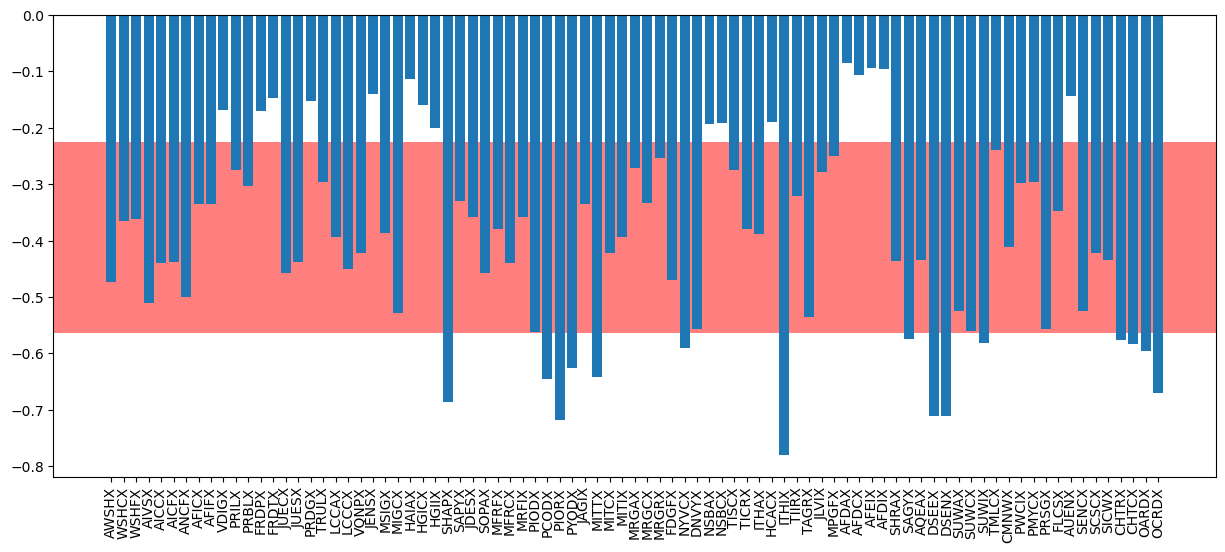

The largest alpha funds by CAPM marked to whole market are ['HAIAX', 'AFDCX', 'AFDIX', 'AFEIX', 'AFDAX'].  Note that the best one is last.
The mutual funds that are 1 stdev above mean with benchmark alpha are ['VDIGX', 'FRDPX', 'FRDTX', 'PRDGX', 'JENSX', 'HAIAX', 'HGICX', 'HGIIX', 'NSBAX', 'NSBCX', 'HCACX', 'AFDAX', 'AFDCX', 'AFEIX', 'AFDIX', 'AUENX']
The mutual funds that are 1 stdev below mean with benchmark alpha are ['SHAPX', 'PCODX', 'PIORX', 'PYODX', 'MITTX', 'NYVCX', 'ITHIX', 'SAGYX', 'DSEEX', 'DSENX', 'SUWIX', 'CHTRX', 'CHTCX', 'OARDX', 'OCRDX']
Average beta of below stdev alpha is 0.9736938594488289 with a stdev on beta of 0.09460205640928213
Average beta of above stdev alpha is 0.8842267730187563 with a stdev on beta of 0.08924164395402252


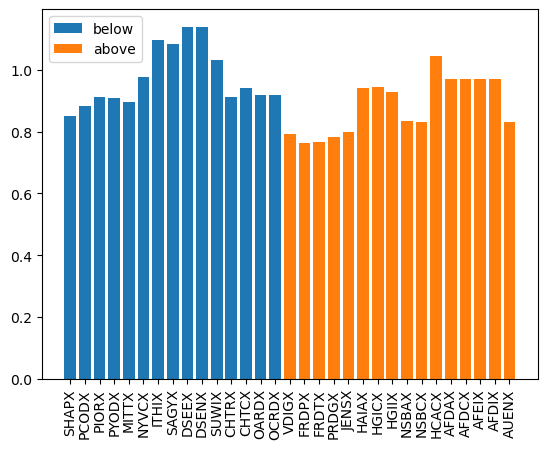

In [46]:
data_analyze_strat_base(1, 'Large Blend')

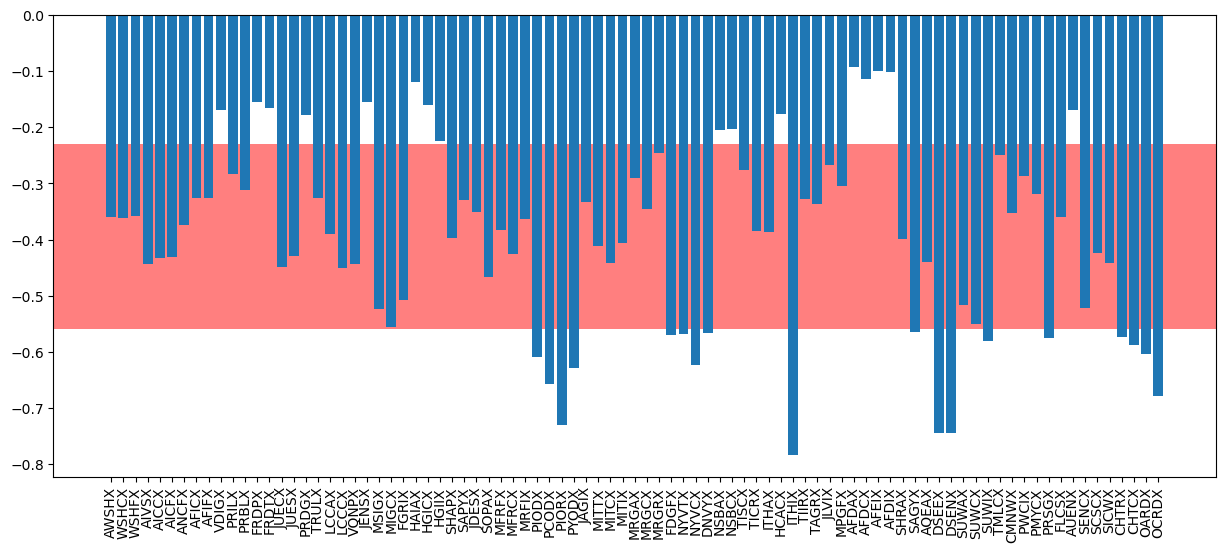

The largest alpha funds by CAPM marked to benchmask are ['HAIAX', 'AFDCX', 'AFDIX', 'AFEIX', 'AFDAX'].  Note last one is best one
The mutual funds that are 1 stdev above mean with benchmark alpha are ['VDIGX', 'FRDPX', 'FRDTX', 'PRDGX', 'JENSX', 'HAIAX', 'HGICX', 'HGIIX', 'NSBAX', 'NSBCX', 'HCACX', 'AFDAX', 'AFDCX', 'AFEIX', 'AFDIX', 'AUENX']
The mutual funds that are 1 stdev above mean with benchmark alpha are ['PIODX', 'PCODX', 'PIORX', 'PYODX', 'FDGFX', 'NYVTX', 'NYVCX', 'DNVYX', 'ITHIX', 'SAGYX', 'DSEEX', 'DSENX', 'SUWIX', 'PRSGX', 'CHTRX', 'CHTCX', 'OARDX', 'OCRDX']
Average beta of below stdev alpha is 1.001849274257947 with a stdev on beta of 0.07779820481188432
Average beta of above stdev alpha is 0.9037075077433944 with a stdev on beta of 0.08354947157114685


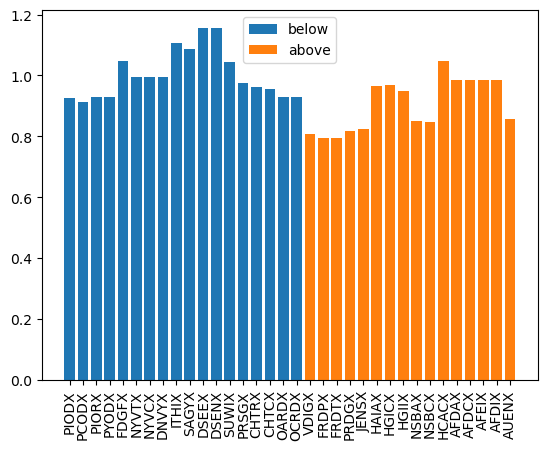

Average corr of below stdev alpha is 0.8704793125752089 with a stdev on corr of 0.027588970895616342
Average corr of above stdev alpha is 0.9210703242833704 with a stdev on corr of 0.09255267993211451


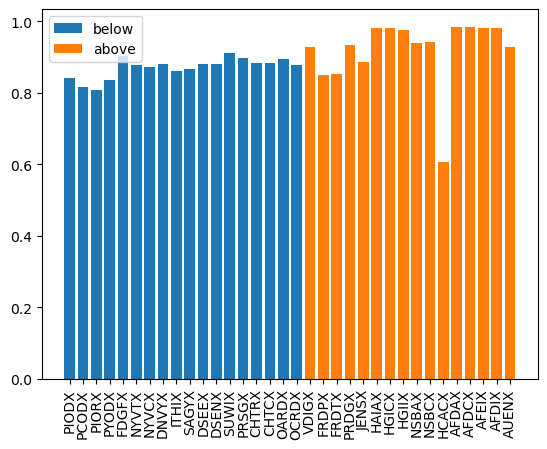

In [47]:
data_analyze_strat_bench(1, 'Large Blend')

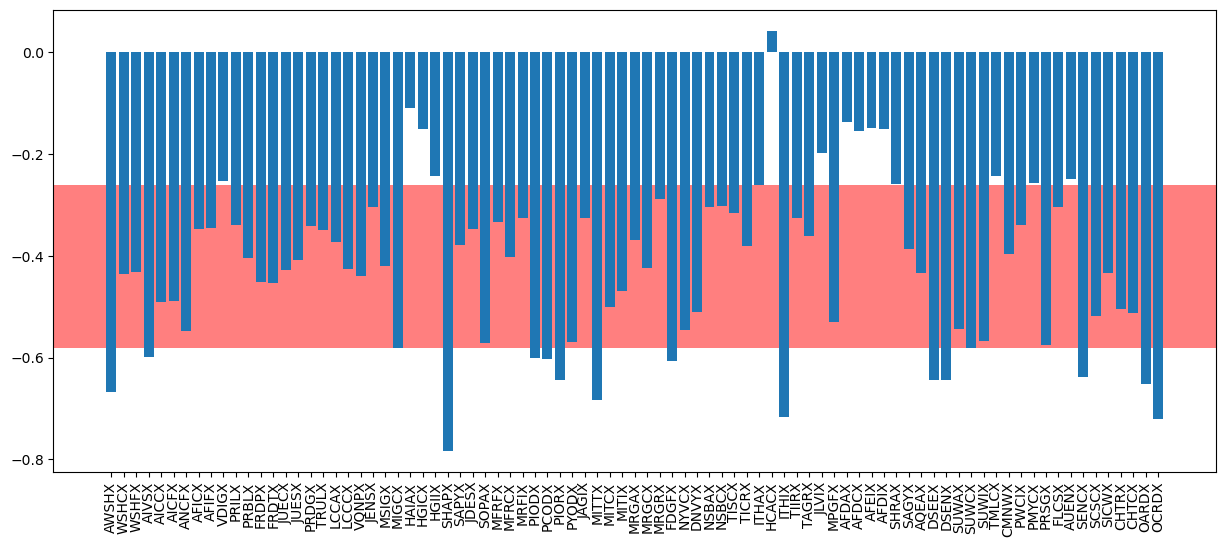

The largest alpha funds by 5-factor are ['AFDIX', 'AFEIX', 'AFDAX', 'HAIAX', 'HCACX'].  Note last one is best one
The mutual funds that are 1 stdev above mean with 5-factor alpha are ['VDIGX', 'HAIAX', 'HGICX', 'HGIIX', 'HCACX', 'JLVIX', 'AFDAX', 'AFDCX', 'AFEIX', 'AFDIX', 'SHRAX', 'TMLCX', 'PMYCX', 'AUENX']
The mutual funds that are 1 stdev above mean with 5-factor alpha are ['AWSHX', 'AIVSX', 'MIGCX', 'SHAPX', 'PIODX', 'PCODX', 'PIORX', 'MITTX', 'FDGFX', 'ITHIX', 'DSEEX', 'DSENX', 'SUWCX', 'SENCX', 'OARDX', 'OCRDX']
Average beta of below stdev alpha is 0.9710452706154282 with a stdev on beta of 0.07783725044277022
Average beta of above stdev alpha is 0.9826487550384781 with a stdev on beta of 0.06372798300043034


Average SMB of below stdev alpha is -0.10196379156701929 with a stdev on SMB of 0.06514000633866819
Average SMB of above stdev alpha is -0.0837286610133352 with a stdev on SMB of 0.12215228933492209


Average HML of below stdev alpha is 0.09966316272780681 with a stdev on H

In [48]:
data_analyze_strat_5(1, 'Large Blend')

## TODO
CAPM w/ benchmark index 

CAPM and FF on different date ranges (look at whether alpha specifically lower during Covid and GFC) (Limit range to between GFC and Covid)

Correlation to benchmark

Identify specifically positive alpha mutual funds, or those which have higher than average

correlation v alpha